In [7]:
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [8]:
 # Corn, Wheat, Soybean Futures Data
tickers = ['ZC=F', 'ZW=F', 'ZS=F'] 

In [9]:
# Take Yearly Data
years = [
    ("2001-01-01", "2002-01-01"),
    ("2002-01-01", "2003-01-01"),
    ("2003-01-01", "2004-01-01"),
    ("2004-01-01", "2005-01-01"),
    ("2005-01-01", "2006-01-01"),
    ("2006-01-01", "2007-01-01"),
    ("2007-01-01", "2008-01-01"),
    ("2008-01-01", "2009-01-01"),
    ("2009-01-01", "2010-01-01"),
    ("2010-01-01", "2011-01-01"),
    ("2011-01-01", "2012-01-01"),
    ("2012-01-01", "2013-01-01"),
    ("2013-01-01", "2014-01-01"),
    ("2014-01-01", "2015-01-01"),
    ("2015-01-01", "2016-01-01"),
    ("2016-01-01", "2017-01-01"),
    ("2017-01-01", "2018-01-01"),
    ("2018-01-01", "2019-01-01"),
    ("2019-01-01", "2020-01-01"),
    ("2020-01-01", "2021-01-01"),
    ("2021-01-01", "2022-01-01"),
    ("2022-01-01", "2023-01-01"),
    ("2023-01-01", "2024-01-01"),
    ("2024-01-01", "2025-01-01")
]

In [10]:
# Dictionary to store yearly data
years_to_closes = {}

# Iterating over the years to gain data for each incremental calender year
for start_date, end_date in years:
    closes = yf.download(tickers, start_date, end_date)["Close"]
    years_to_closes[(start_date, end_date)] = closes


/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_78674/3701682953.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start_date, end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_78674/3701682953.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start_date, end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_78674/3701682953.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start_date, end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_78674/3701682953.py:6: FutureWarning: YF.download() has changed a

In [5]:
train_test_closes = {}

for year, closes in years_to_closes.items():
   
    # Split the closes data into train and test sets (80% train, 20% test by default)
    train_data, test_data = train_test_split(closes, test_size=0.2, shuffle=False)
    
    print(closes)
    # Store the result in the new dictionary
    train_test_closes[year] = {
        'train': train_data.dropna(),
        'test': test_data.dropna()
    }


Ticker        ZC=F    ZS=F    ZW=F
Date                              
2001-01-02  222.50  500.00  277.25
2001-01-03     NaN  493.75  275.75
2001-01-04     NaN  499.50  283.00
2001-01-05     NaN  493.75  284.25
2001-01-08     NaN  488.00  281.25
...            ...     ...     ...
2001-12-24  203.50  435.50  288.75
2001-12-26  199.75     NaN     NaN
2001-12-27  202.00  428.75  288.50
2001-12-28  200.75  428.50  292.50
2001-12-31  199.75  423.75  291.00

[251 rows x 3 columns]
Ticker        ZC=F    ZS=F    ZW=F
Date                              
2002-01-02  199.50  422.75  292.00
2002-01-03  202.00  418.50  292.25
2002-01-04  202.50  423.50  301.00
2002-01-07  203.50  428.00  308.00
2002-01-08  204.00  430.00  304.50
...            ...     ...     ...
2002-12-24  242.75  572.75  345.75
2002-12-26  242.75  565.75  338.25
2002-12-27  239.75  569.75  333.00
2002-12-30  235.75  565.75  329.00
2002-12-31  235.75  569.50  325.00

[252 rows x 3 columns]
Ticker        ZC=F    ZS=F    ZW=F
Date   

In [11]:
first_year = next(iter(train_test_closes.keys()))
tickers = list(train_test_closes[first_year]['train'].columns)

max_lag = 10               # max AR order to search over
h = 21                     # ~1 trading month
years_sorted = sorted(train_test_closes.keys())

# ----------------------------------------
# 1. TRAIN AR(p) PER YEAR & TICKER
# ----------------------------------------

ar_year_to_models = {}

for year in years_sorted:
    print(f"\n=== Training AR on year: {year} ===")
    train_df = train_test_closes[year]['train'][tickers]

    ar_year_to_models[year] = {}

    for ticker in tickers:
        series = train_df[ticker].dropna()

        # work on numeric index to avoid DatetimeIndex predict weirdness
        series_num = series.reset_index(drop=True)

        if len(series_num) < 20:
            print(f"  {ticker}: not enough data, skipping.")
            continue

        # select lag order by AIC up to max_lag
        sel = ar_select_order(series_num, maxlag=max_lag, ic='aic', old_names=False)

        if sel.ar_lags is None or len(sel.ar_lags) == 0:
            p = 1
        else:
            p = int(np.max(sel.ar_lags))

        print(f"  {ticker}: selected AR({p})")

        # fit AR(p)
        ar_model = AutoReg(series_num, lags=p, old_names=False)
        ar_res = ar_model.fit()

        ar_year_to_models[year][ticker] = {
            "lags": p,
            "model": ar_res,
        }


=== Training AR on year: ('2001-01-01', '2002-01-01') ===
  ZC=F: selected AR(1)
  ZS=F: selected AR(3)
  ZW=F: selected AR(1)

=== Training AR on year: ('2002-01-01', '2003-01-01') ===
  ZC=F: selected AR(1)
  ZS=F: selected AR(1)
  ZW=F: selected AR(1)

=== Training AR on year: ('2003-01-01', '2004-01-01') ===
  ZC=F: selected AR(5)
  ZS=F: selected AR(2)
  ZW=F: selected AR(1)

=== Training AR on year: ('2004-01-01', '2005-01-01') ===
  ZC=F: selected AR(1)
  ZS=F: selected AR(6)
  ZW=F: selected AR(2)

=== Training AR on year: ('2005-01-01', '2006-01-01') ===
  ZC=F: selected AR(2)
  ZS=F: selected AR(1)
  ZW=F: selected AR(1)

=== Training AR on year: ('2006-01-01', '2007-01-01') ===
  ZC=F: selected AR(1)
  ZS=F: selected AR(3)
  ZW=F: selected AR(7)

=== Training AR on year: ('2007-01-01', '2008-01-01') ===
  ZC=F: selected AR(1)
  ZS=F: selected AR(1)
  ZW=F: selected AR(1)

=== Training AR on year: ('2008-01-01', '2009-01-01') ===
  ZC=F: selected AR(2)
  ZS=F: selected AR(2)


=== AR month-ahead forecast: ('2001-01-01', '2002-01-01') ===


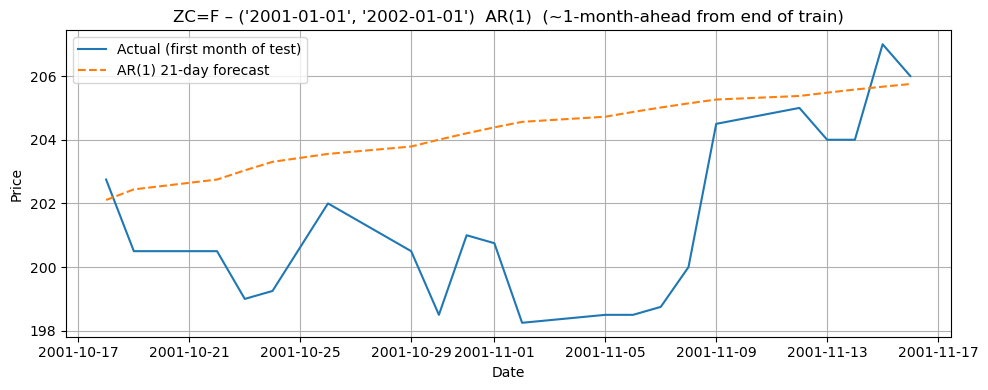

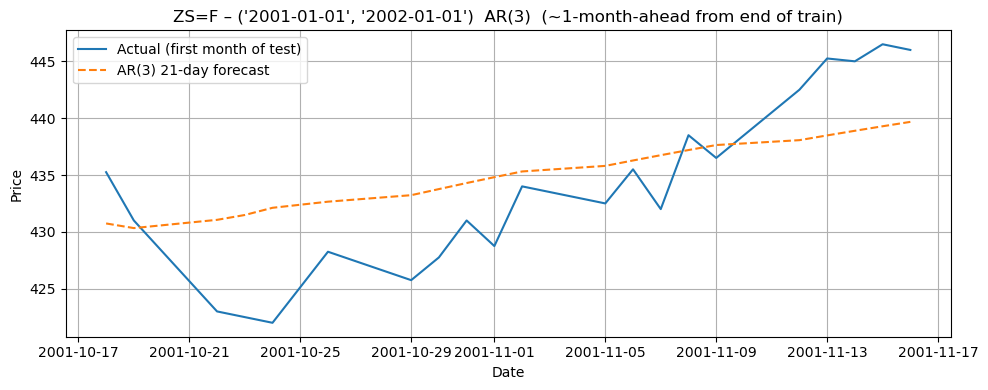

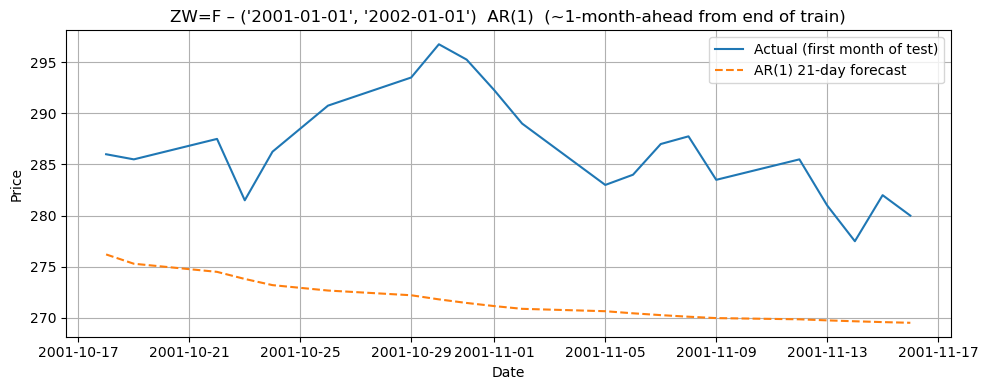


=== AR month-ahead forecast: ('2002-01-01', '2003-01-01') ===


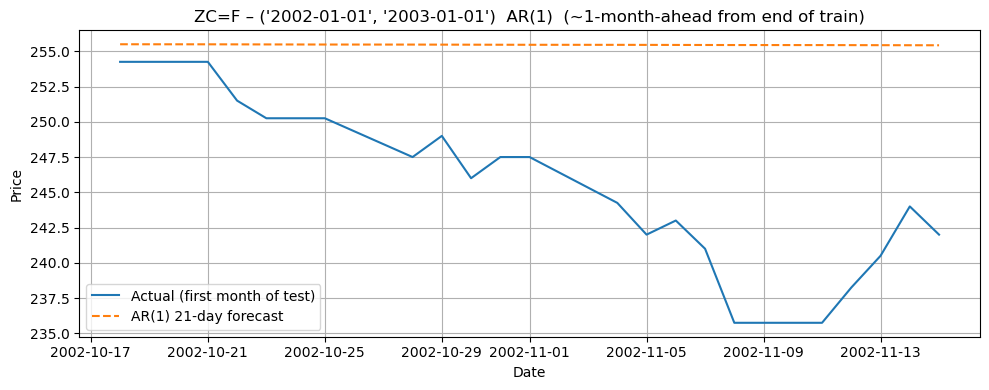

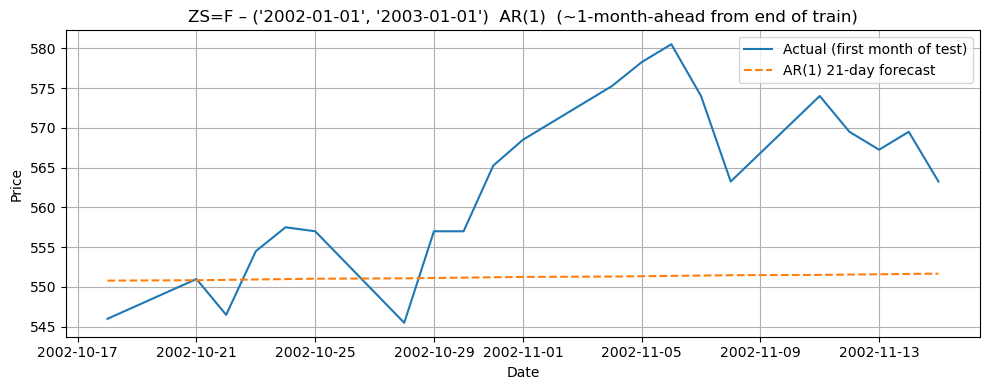

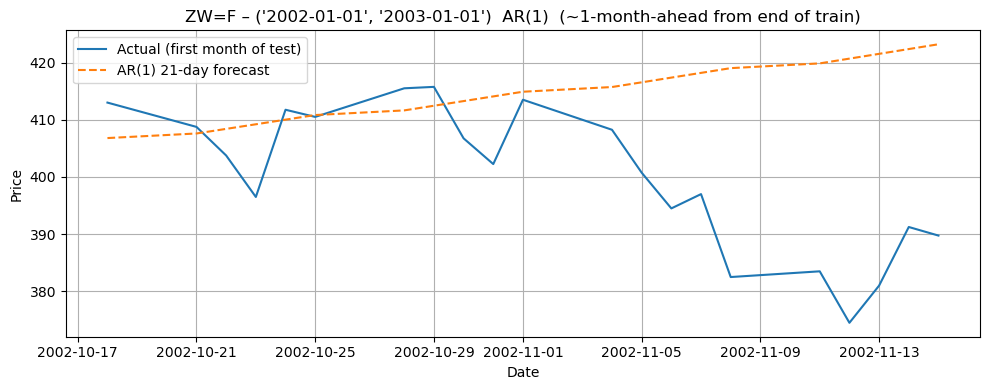


=== AR month-ahead forecast: ('2003-01-01', '2004-01-01') ===


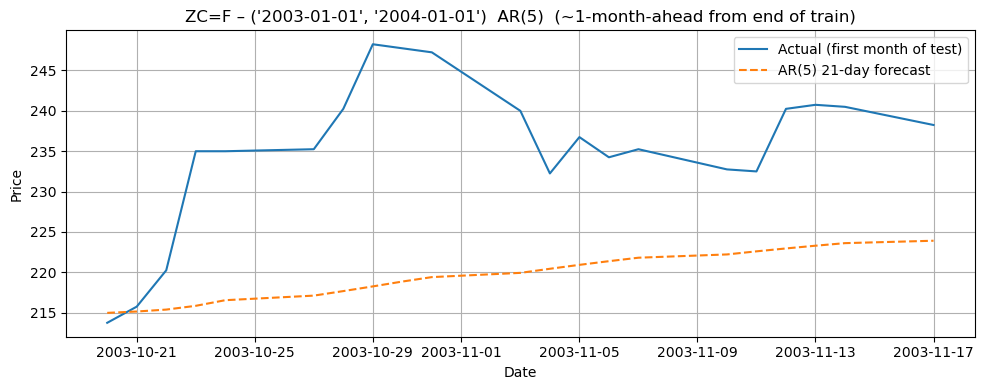

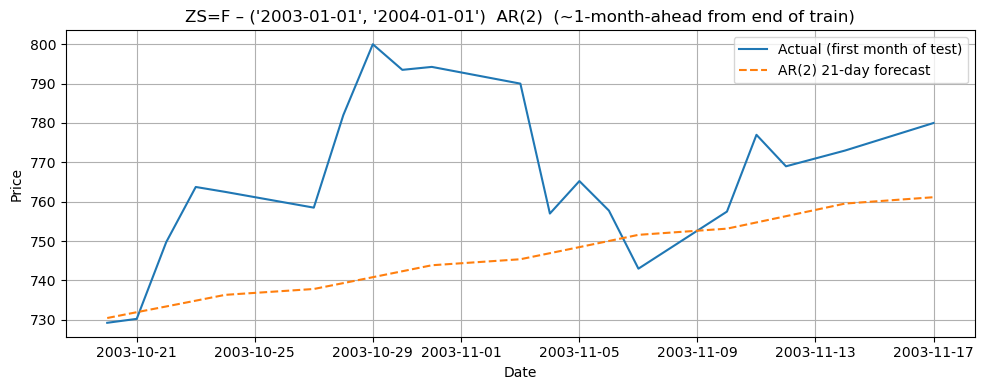

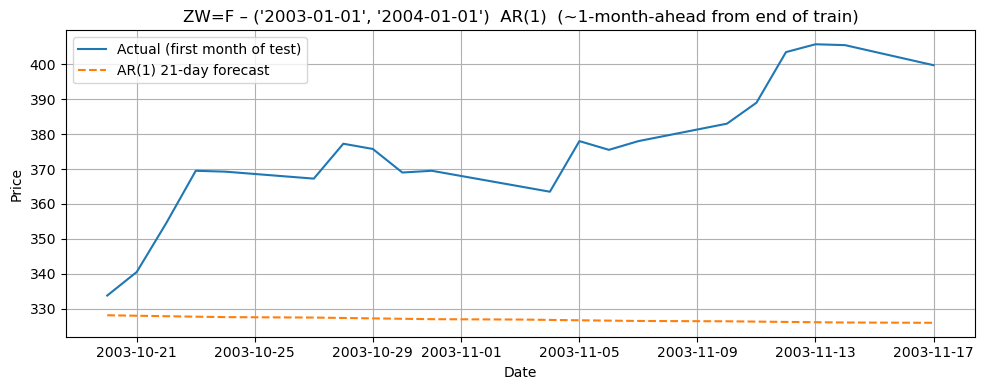


=== AR month-ahead forecast: ('2004-01-01', '2005-01-01') ===


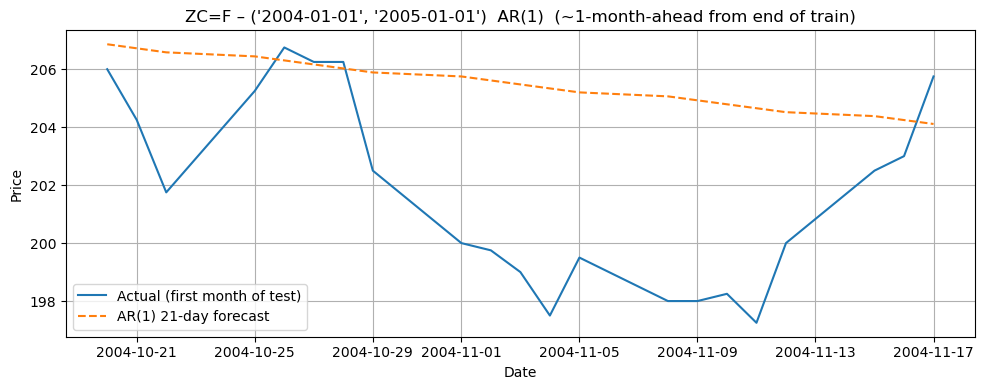

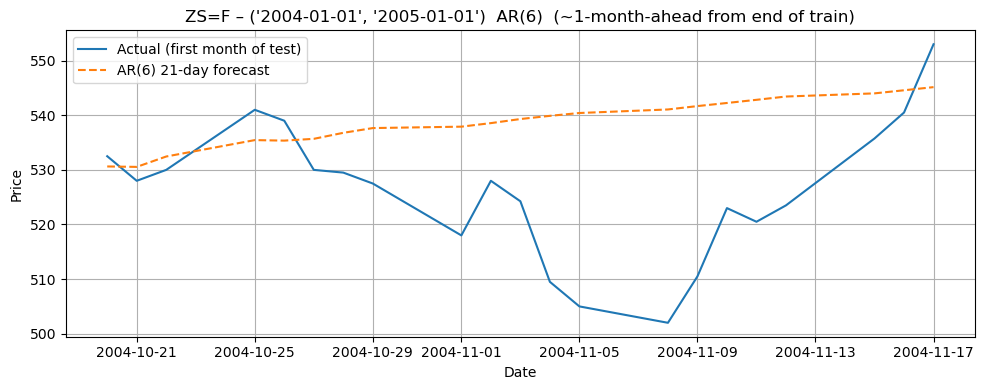

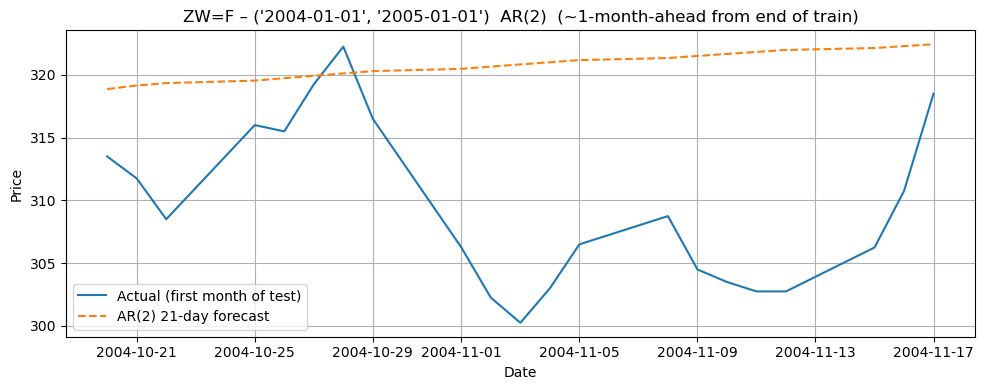


=== AR month-ahead forecast: ('2005-01-01', '2006-01-01') ===


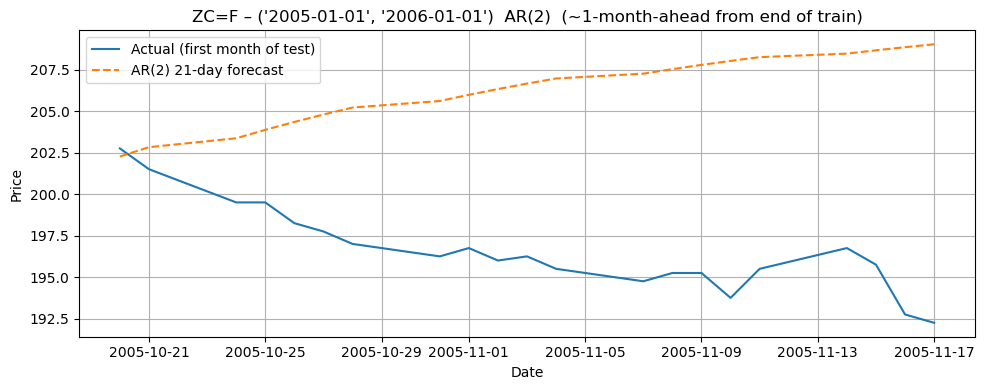

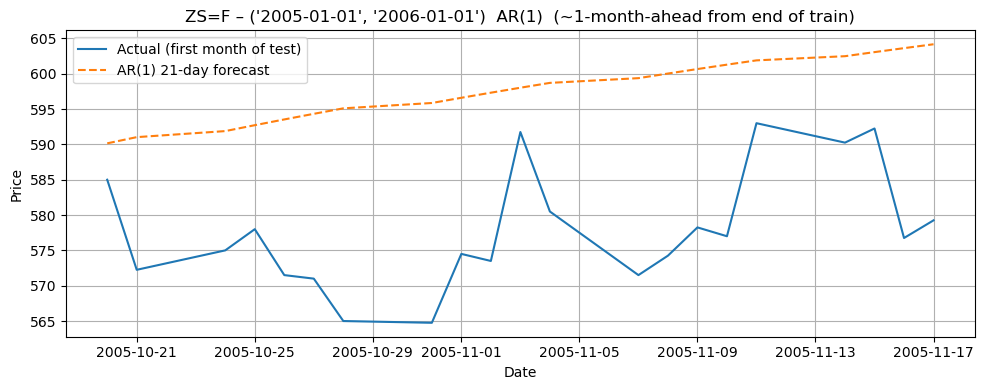

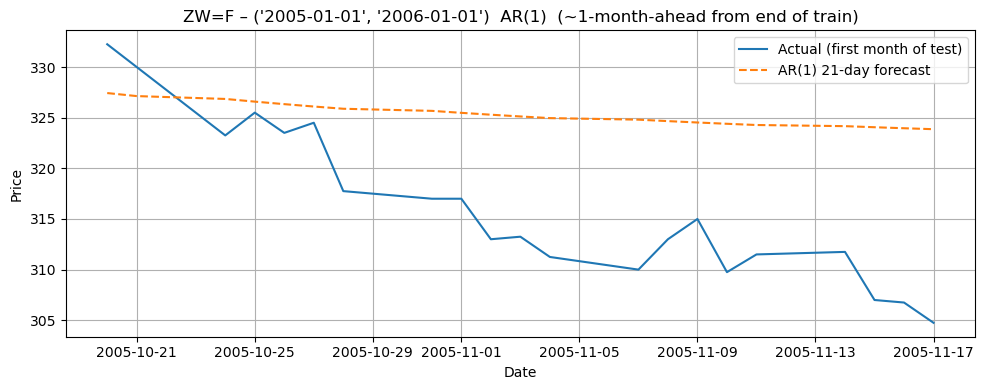


=== AR month-ahead forecast: ('2006-01-01', '2007-01-01') ===


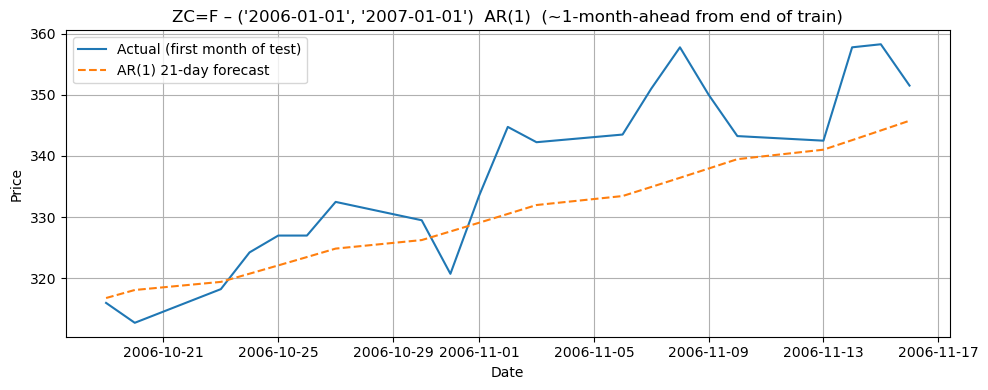

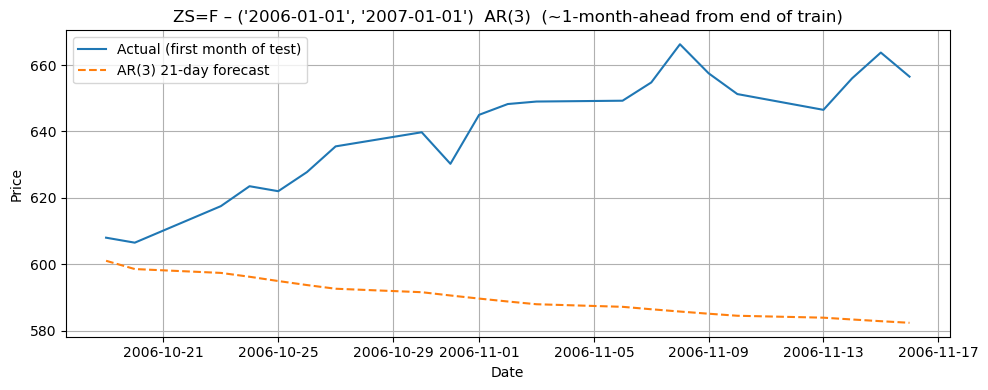

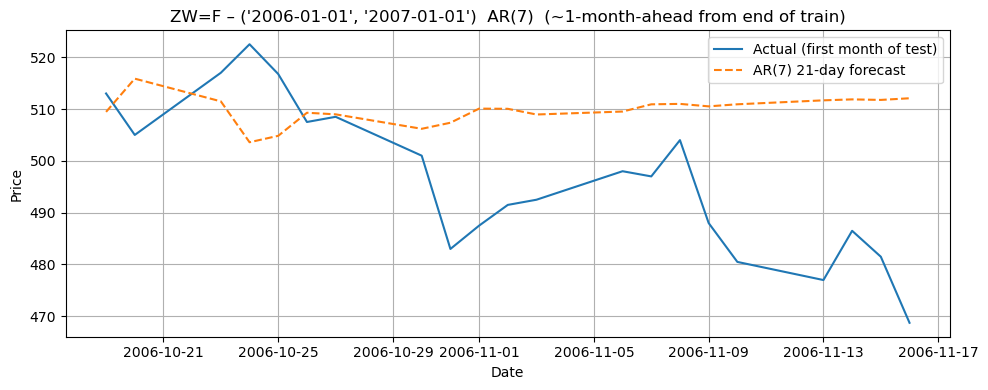


=== AR month-ahead forecast: ('2007-01-01', '2008-01-01') ===


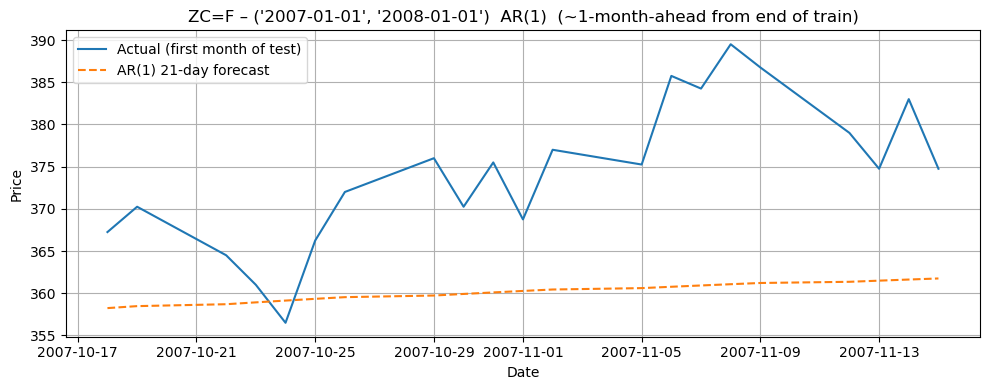

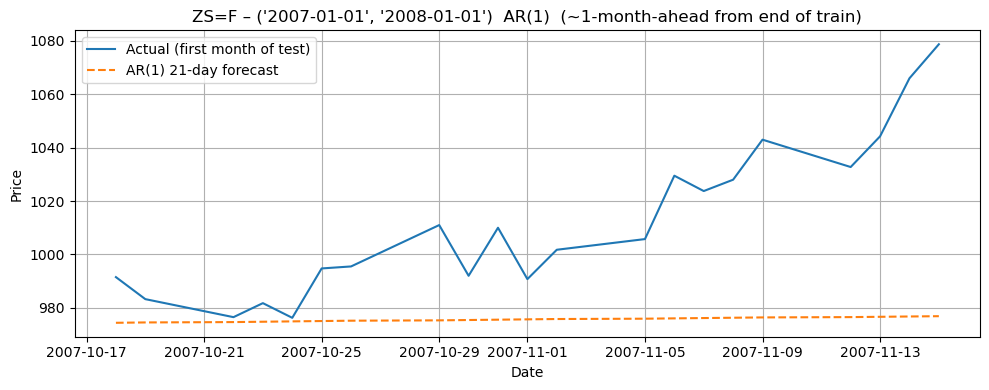

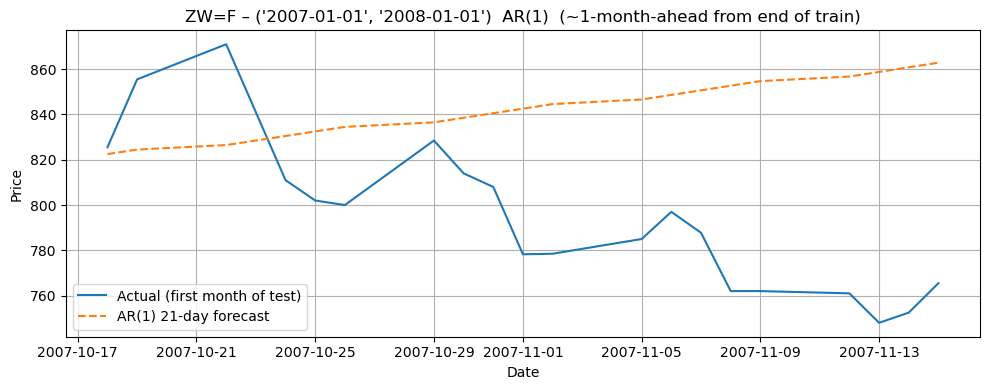


=== AR month-ahead forecast: ('2008-01-01', '2009-01-01') ===


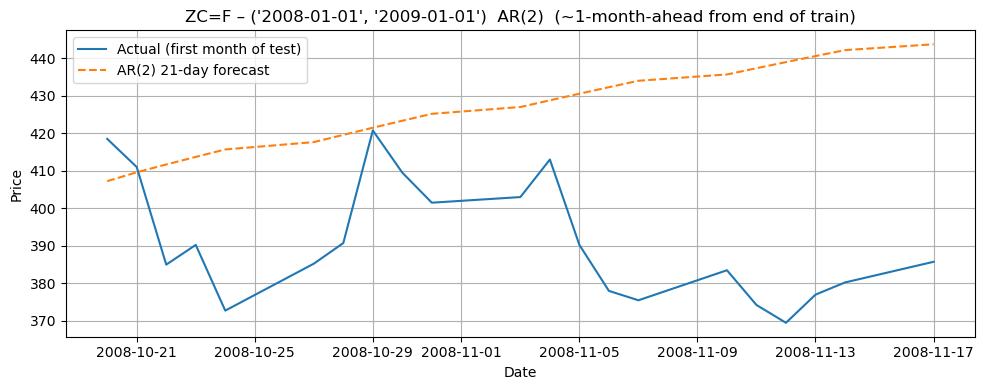

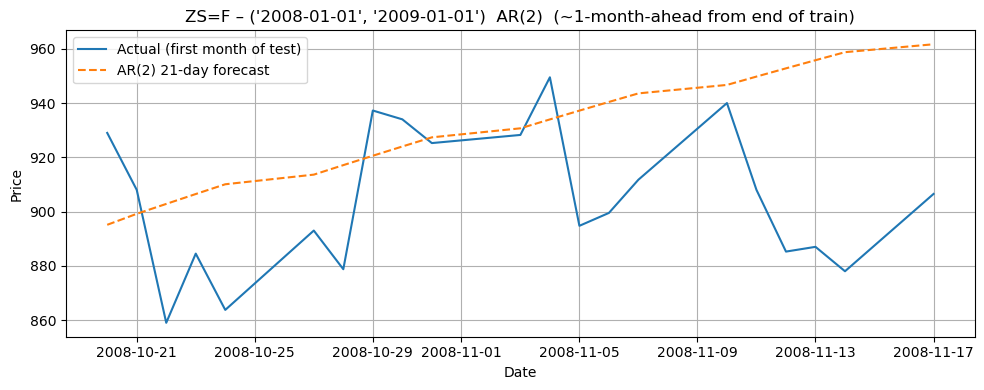

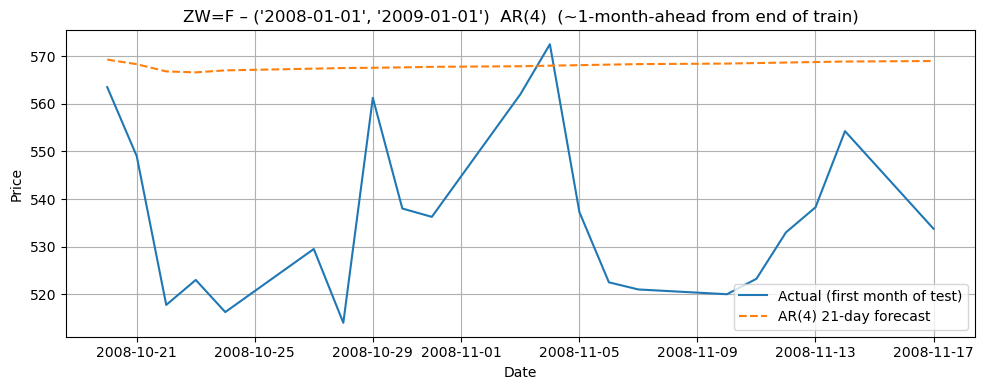


=== AR month-ahead forecast: ('2009-01-01', '2010-01-01') ===


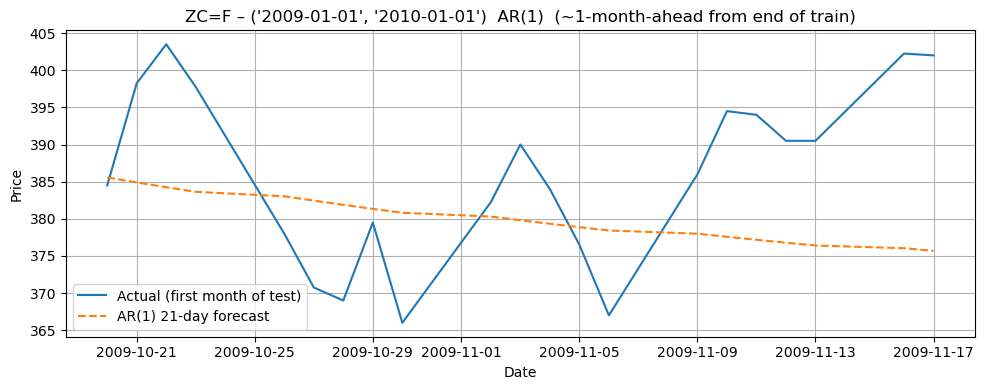

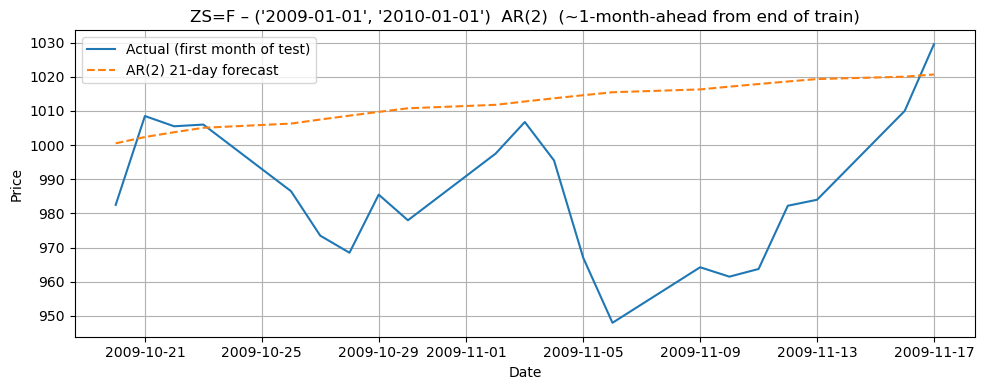

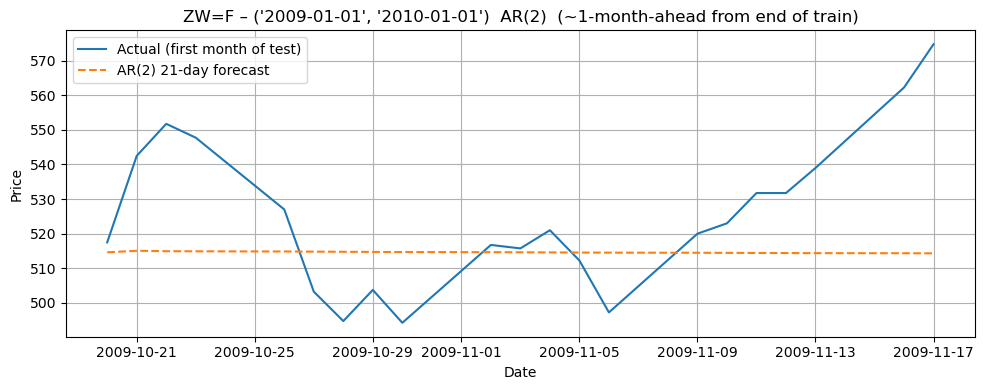


=== AR month-ahead forecast: ('2010-01-01', '2011-01-01') ===


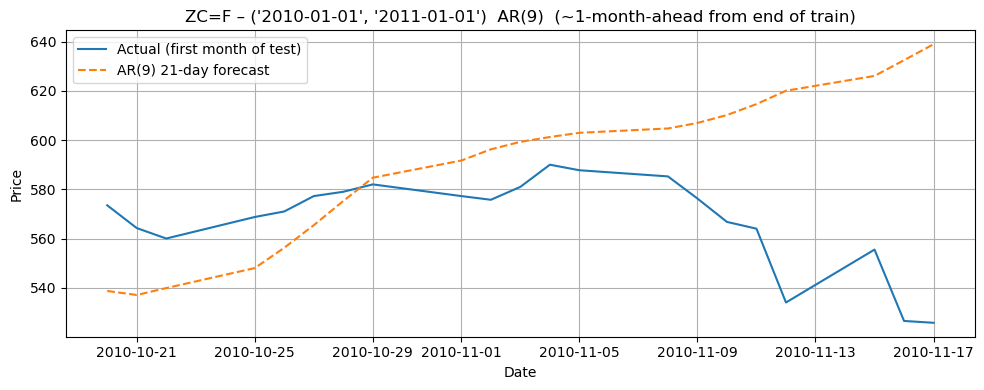

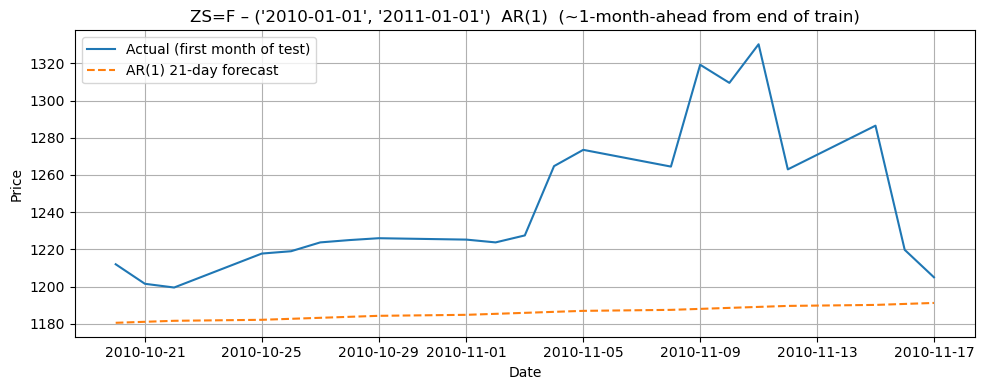

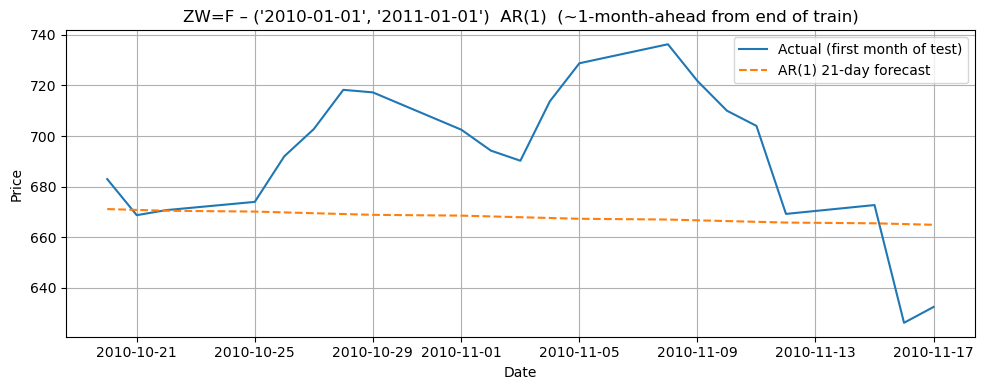


=== AR month-ahead forecast: ('2011-01-01', '2012-01-01') ===


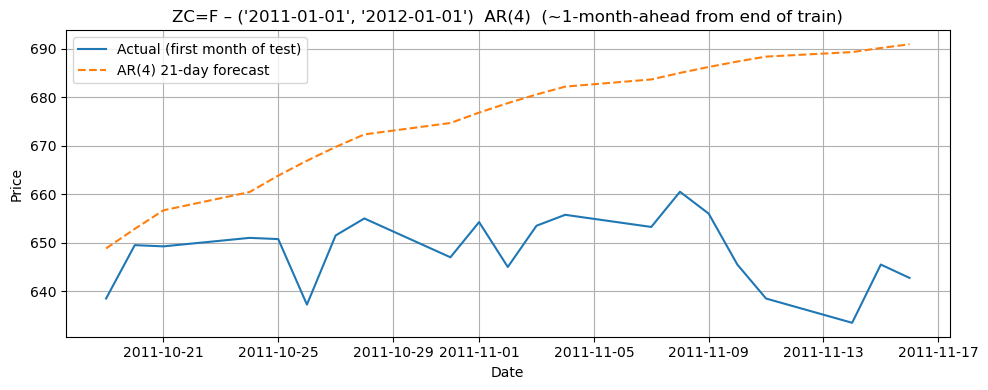

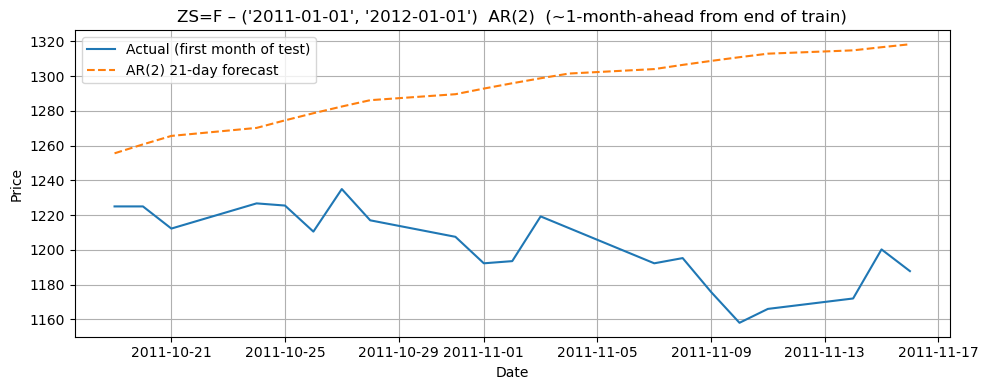

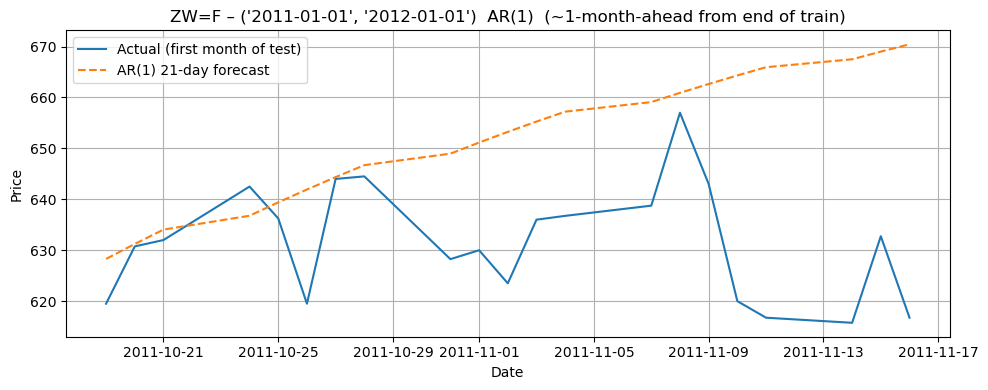


=== AR month-ahead forecast: ('2012-01-01', '2013-01-01') ===


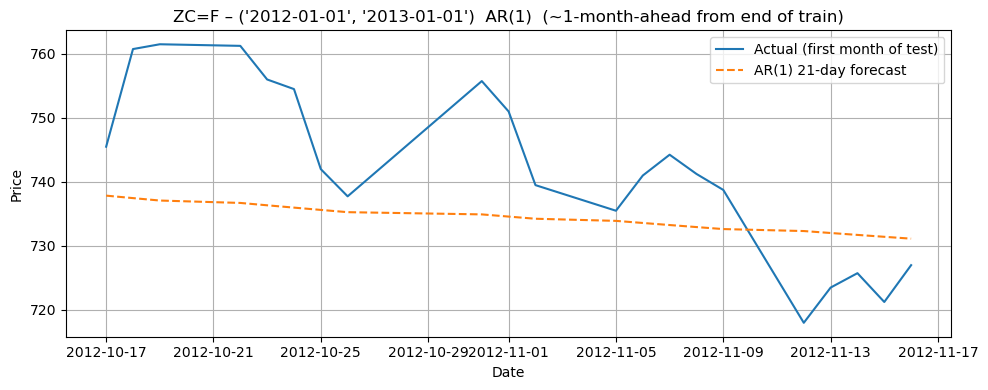

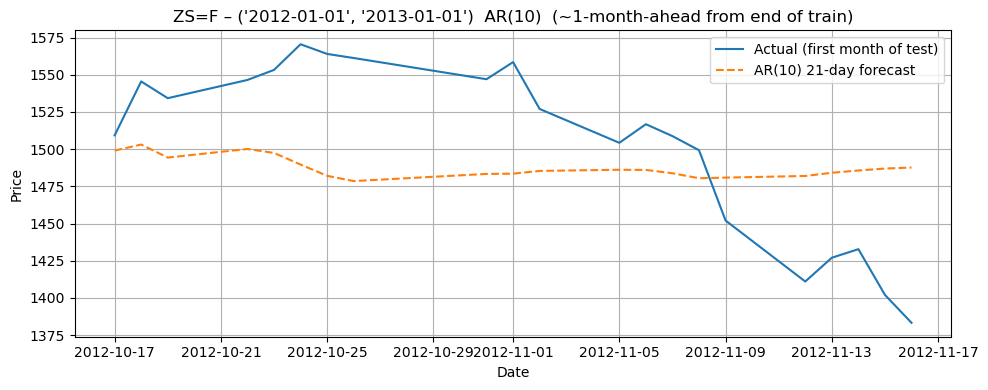

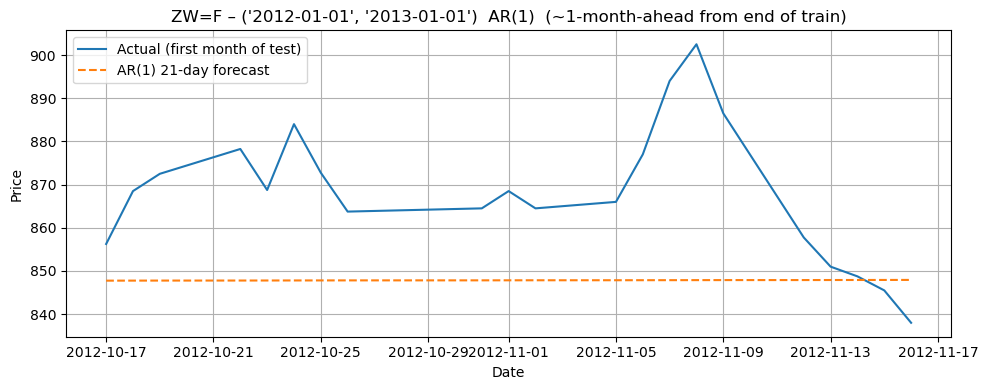


=== AR month-ahead forecast: ('2013-01-01', '2014-01-01') ===


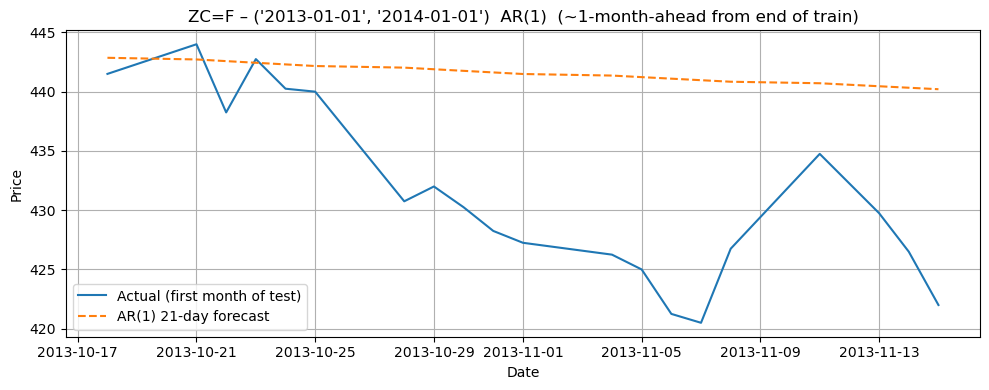

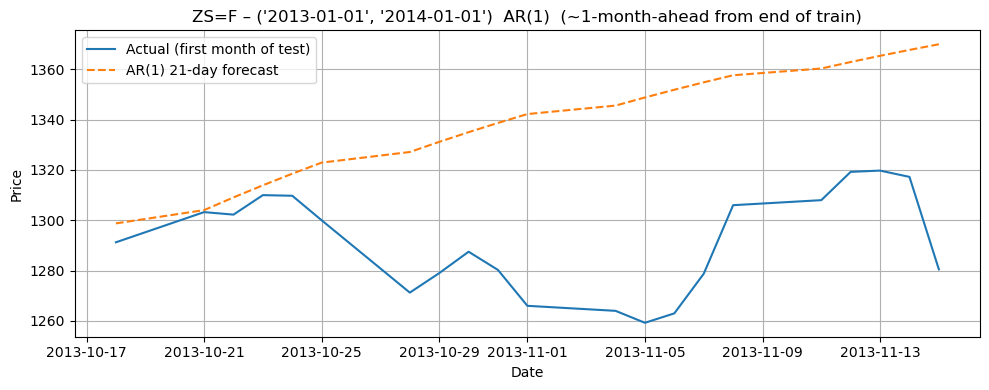

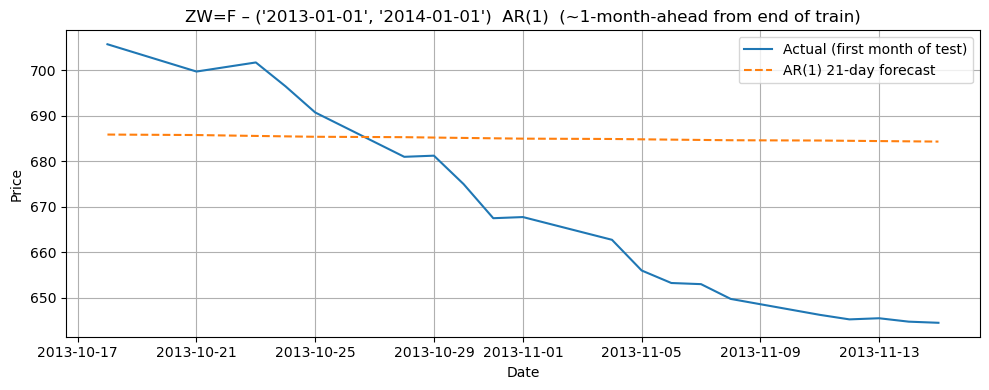


=== AR month-ahead forecast: ('2014-01-01', '2015-01-01') ===


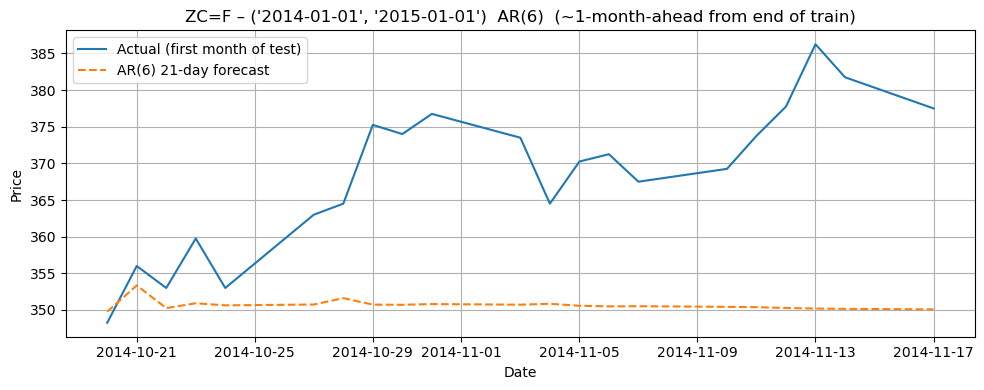

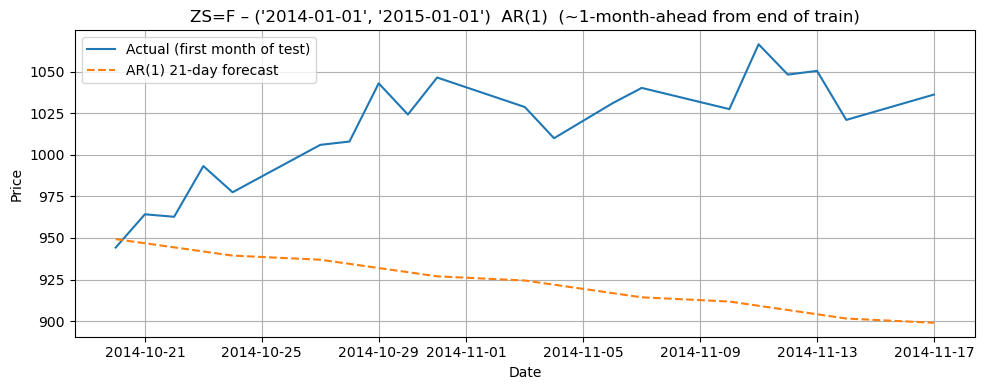

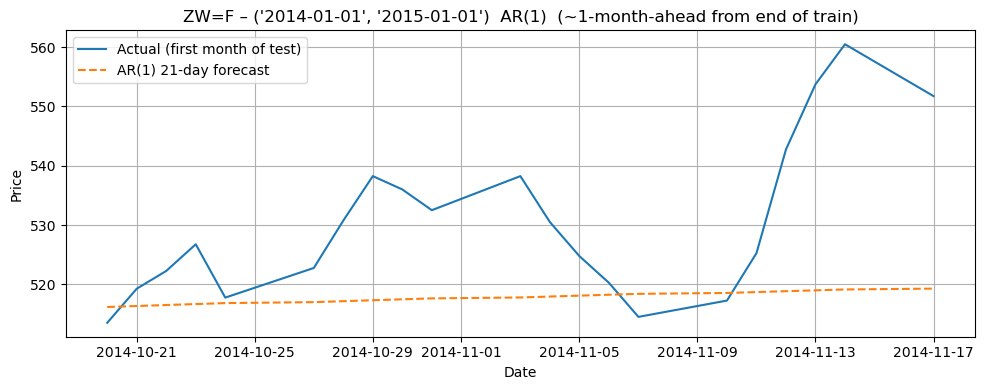


=== AR month-ahead forecast: ('2015-01-01', '2016-01-01') ===


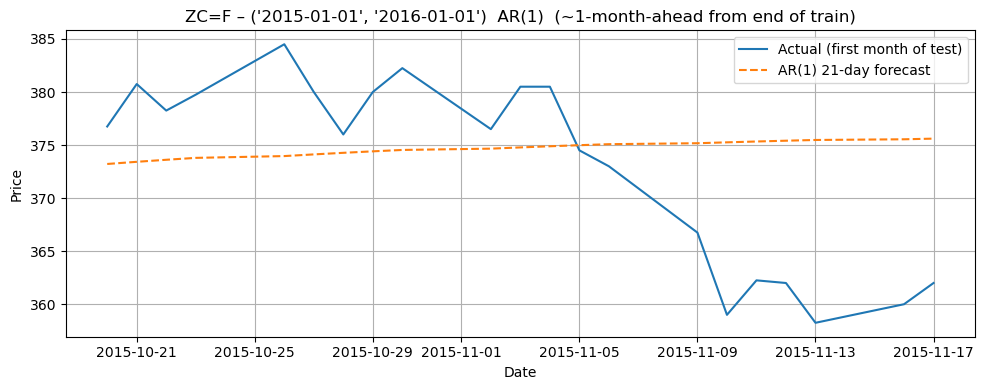

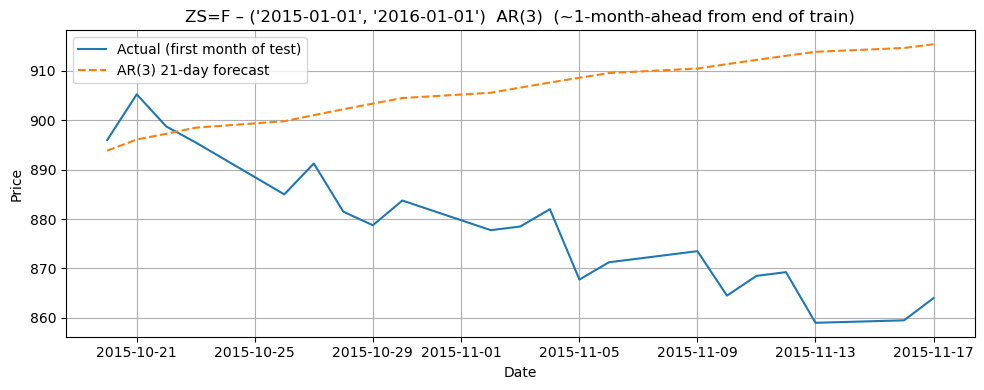

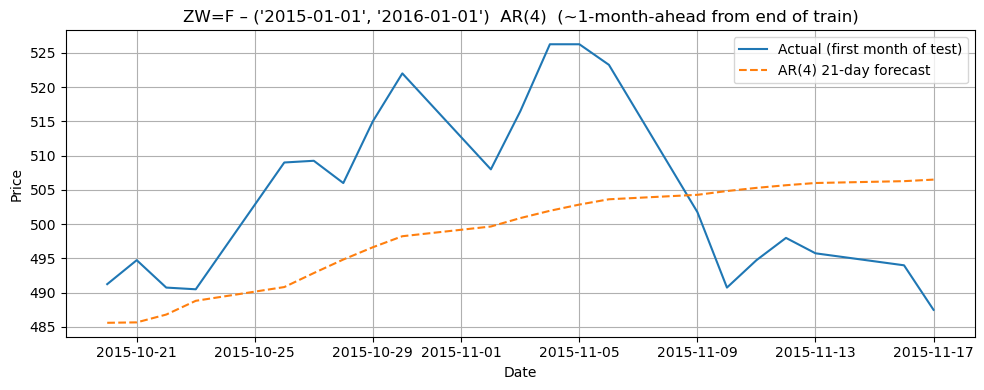


=== AR month-ahead forecast: ('2016-01-01', '2017-01-01') ===


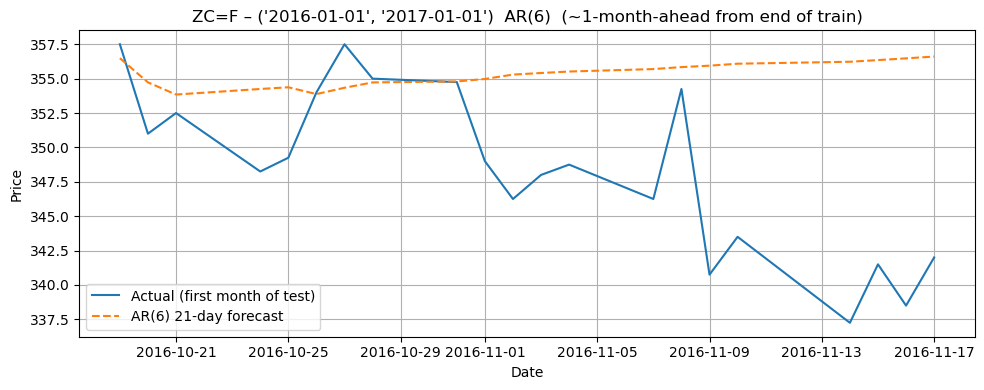

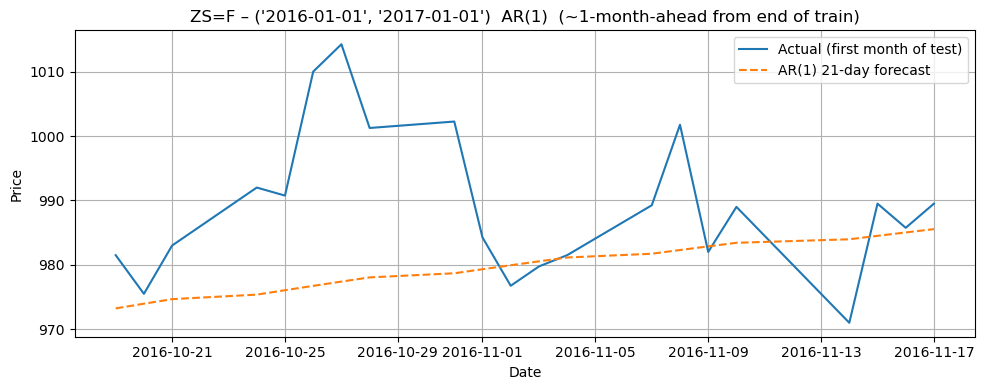

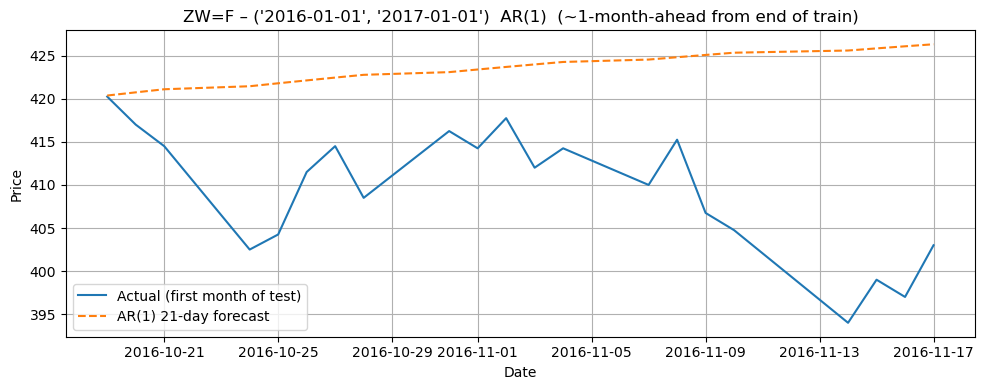


=== AR month-ahead forecast: ('2017-01-01', '2018-01-01') ===


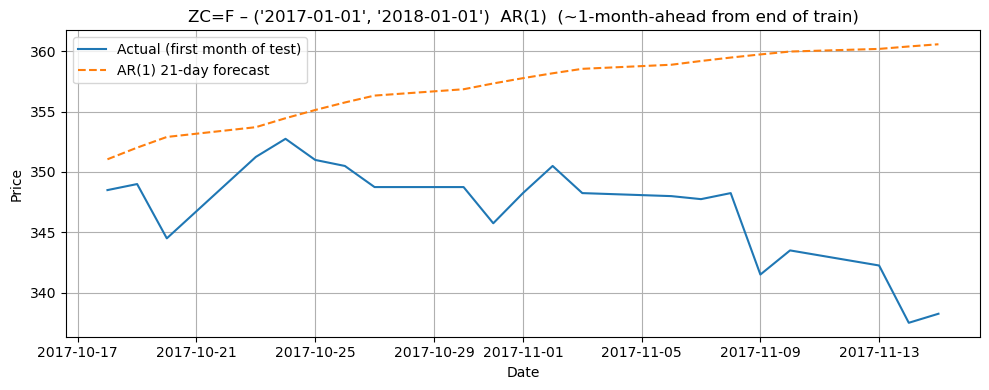

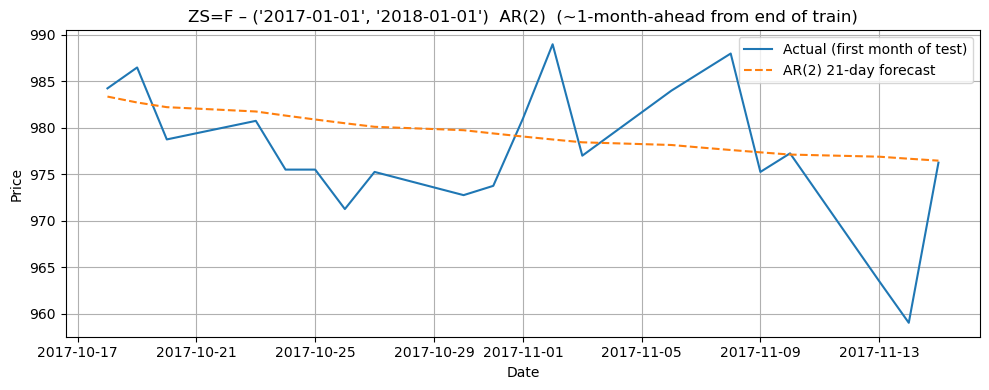

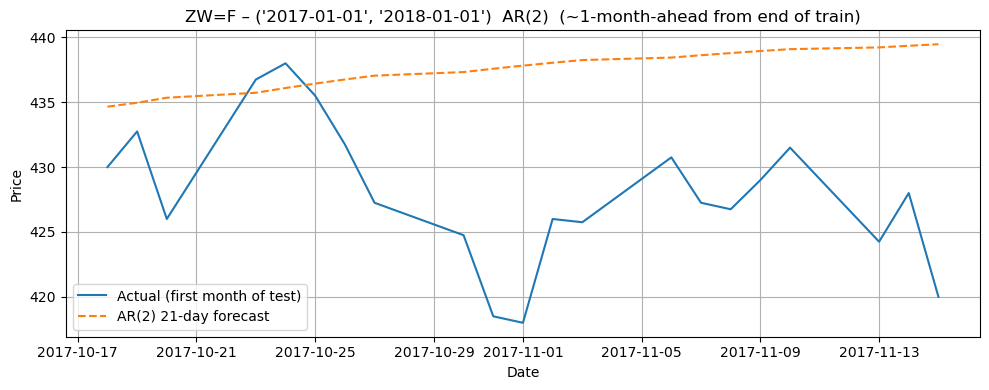


=== AR month-ahead forecast: ('2018-01-01', '2019-01-01') ===


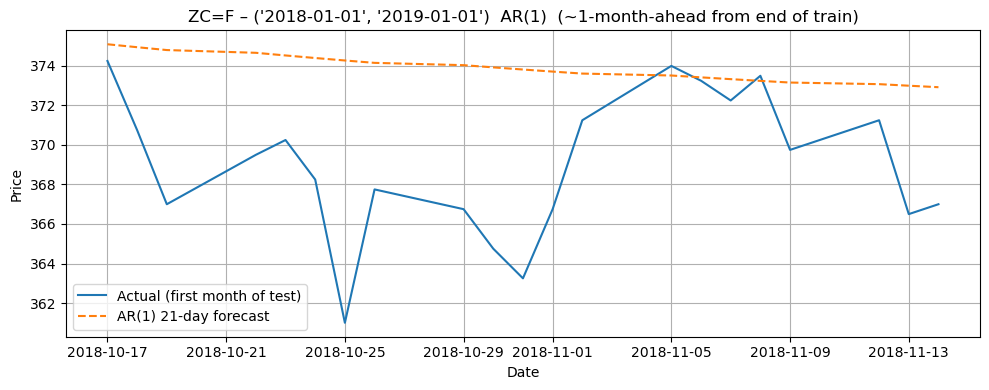

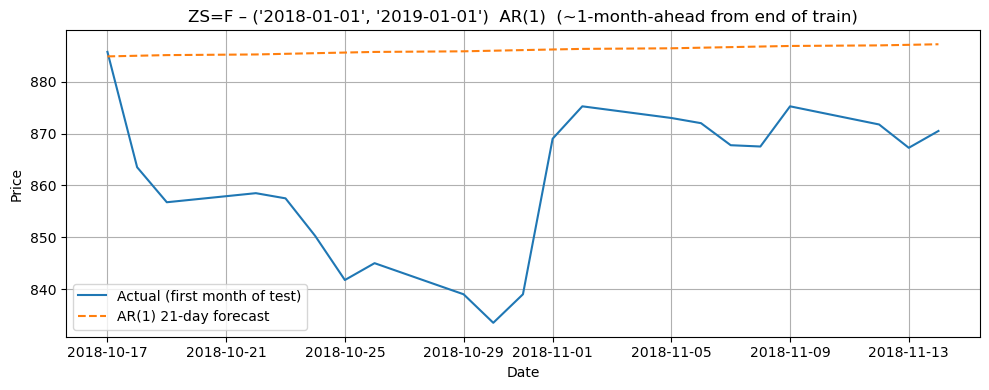

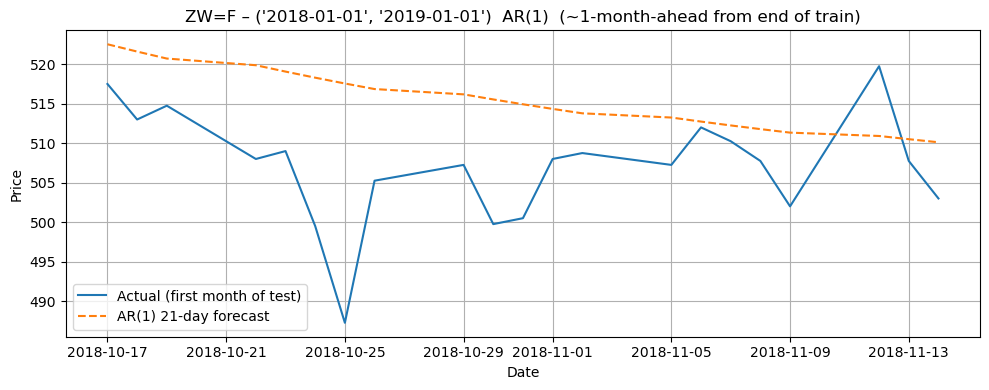


=== AR month-ahead forecast: ('2019-01-01', '2020-01-01') ===


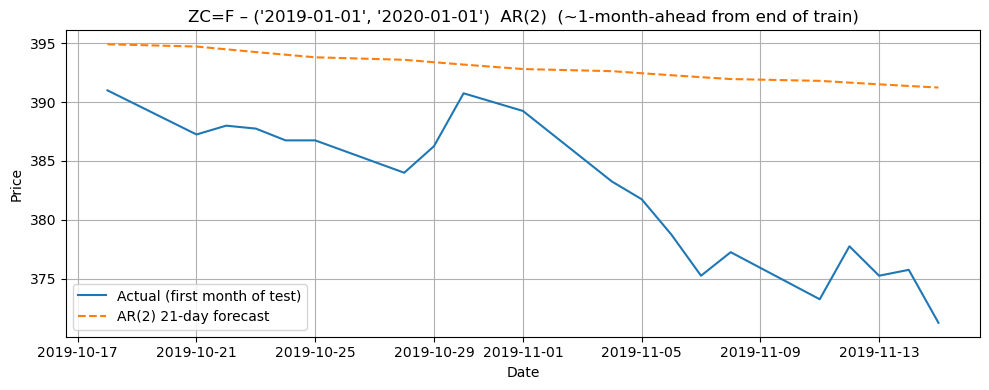

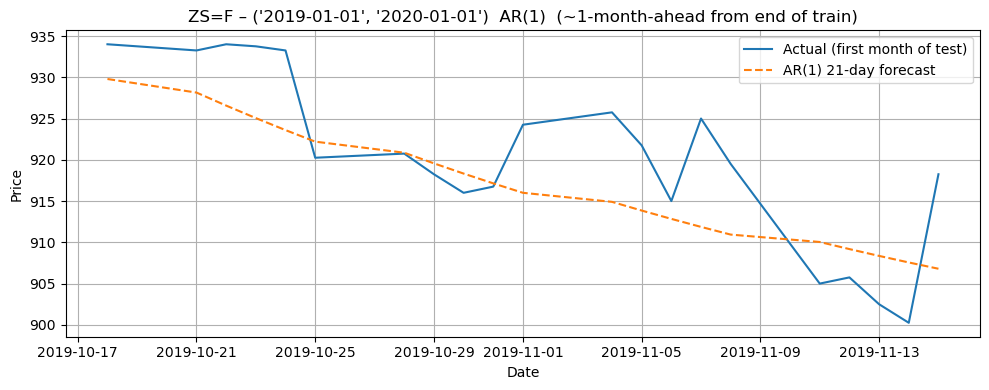

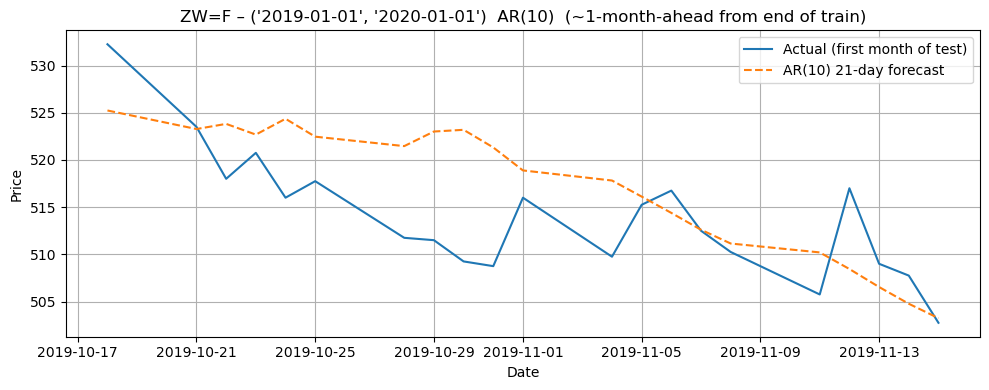


=== AR month-ahead forecast: ('2020-01-01', '2021-01-01') ===


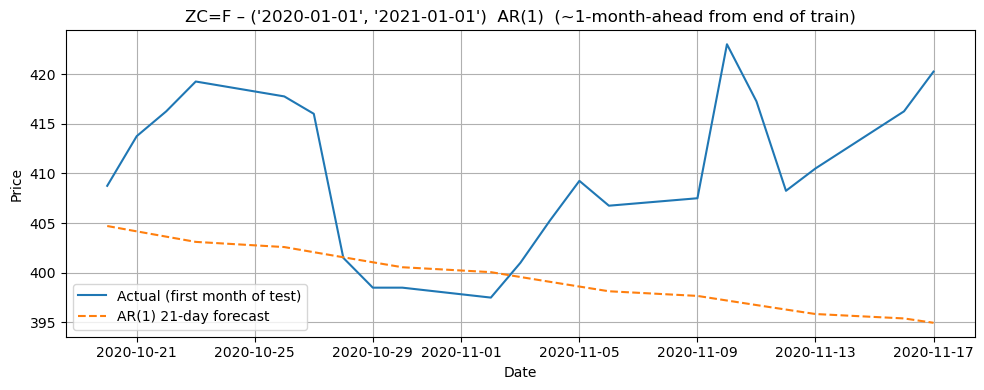

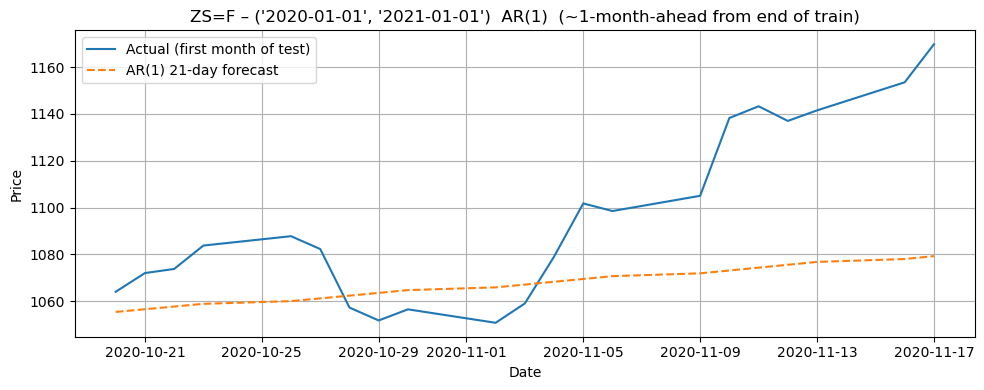

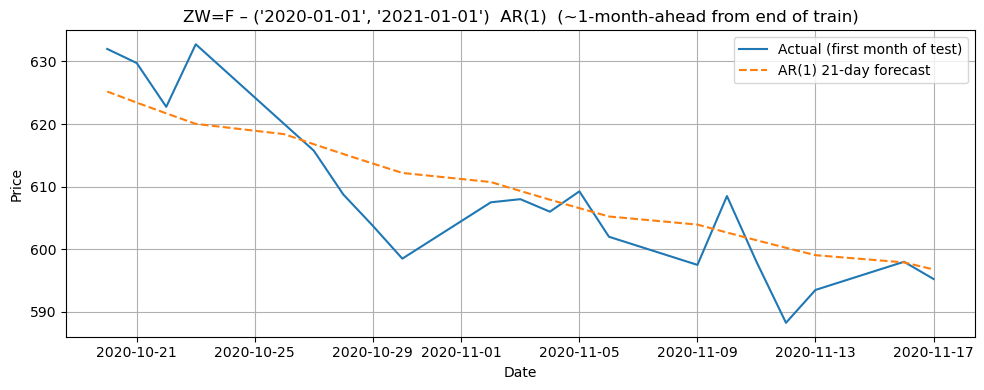


=== AR month-ahead forecast: ('2021-01-01', '2022-01-01') ===


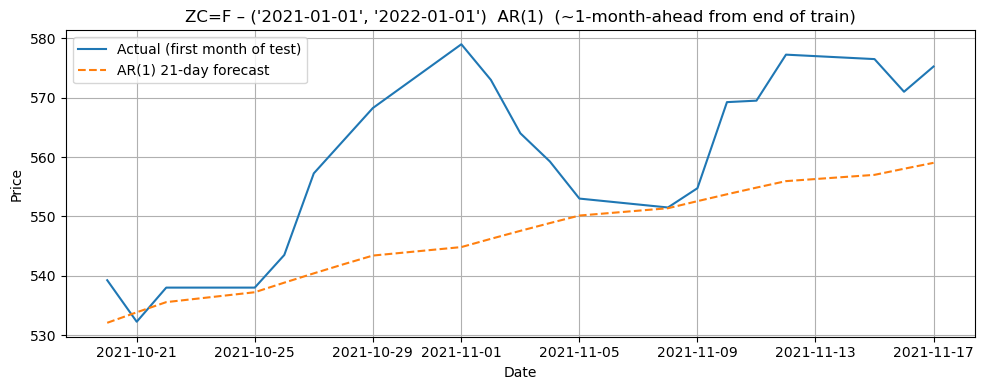

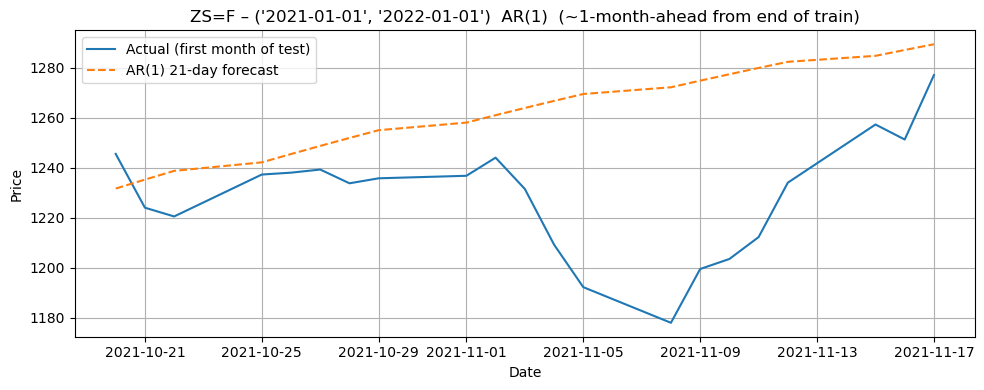

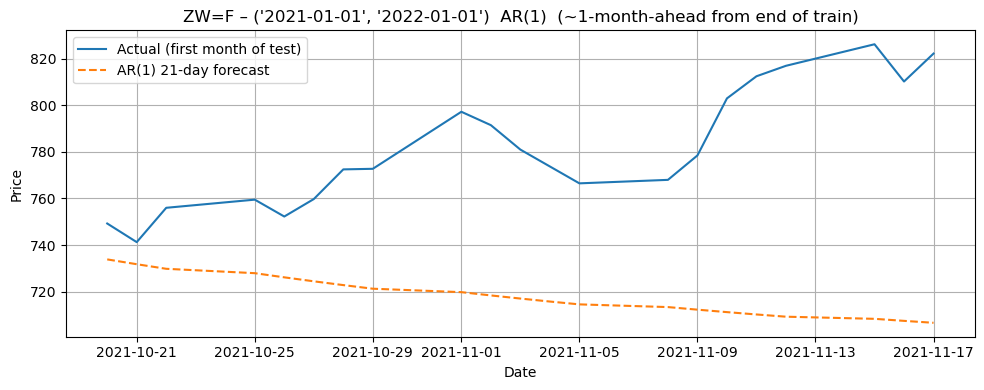


=== AR month-ahead forecast: ('2022-01-01', '2023-01-01') ===


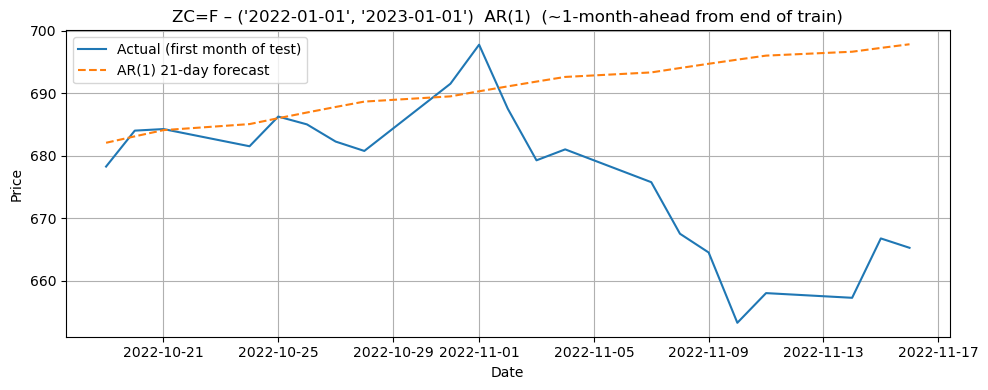

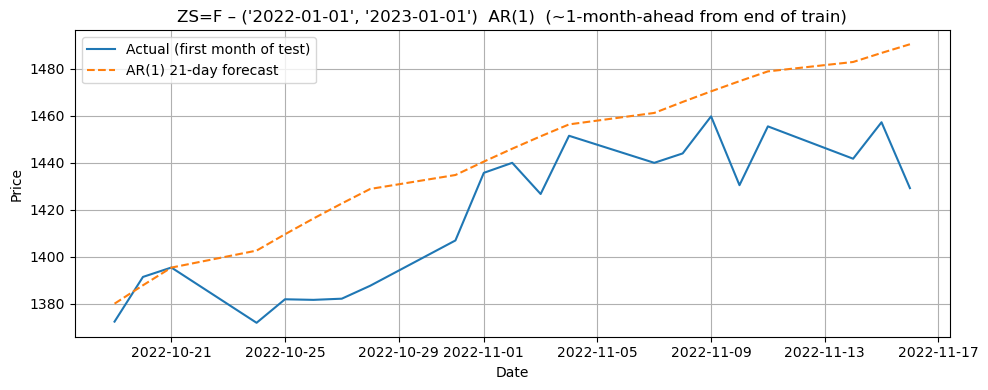

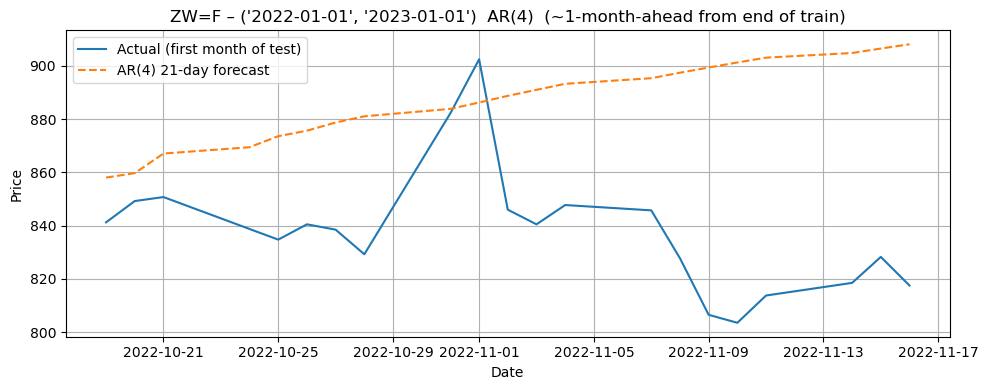


=== AR month-ahead forecast: ('2023-01-01', '2024-01-01') ===


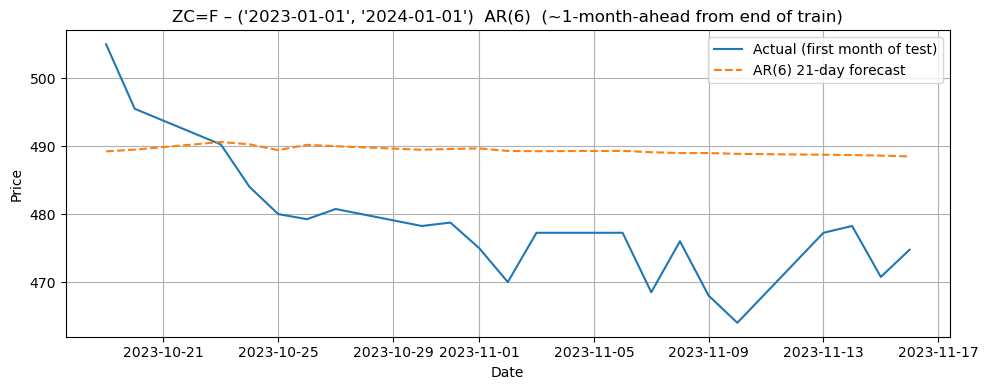

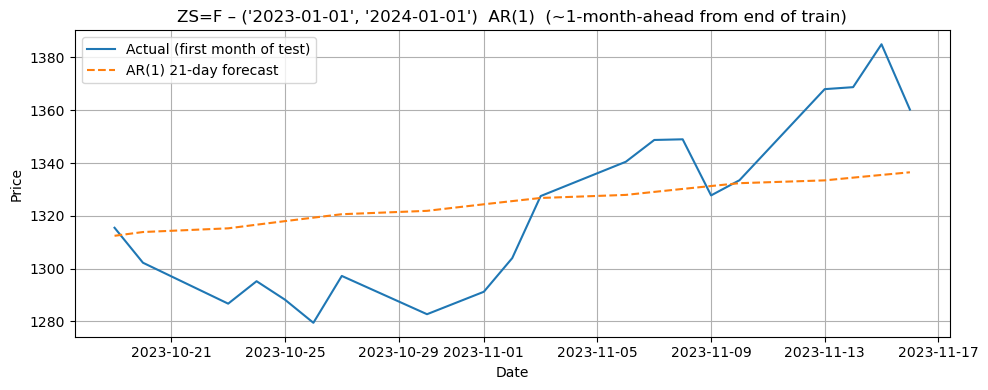

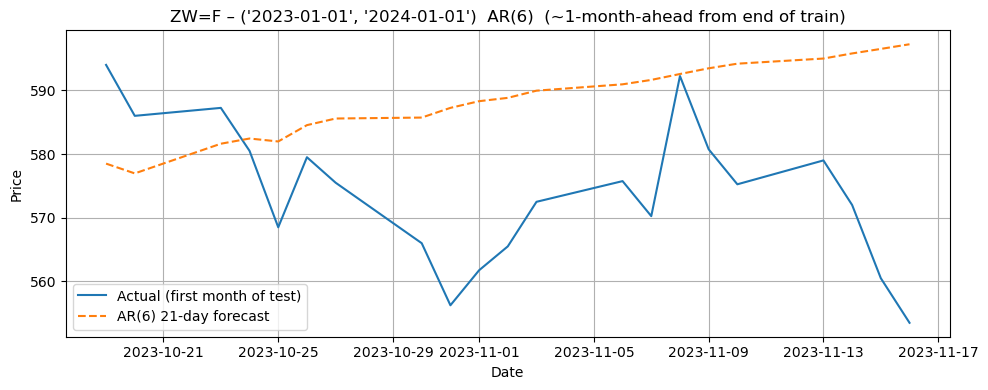


=== AR month-ahead forecast: ('2024-01-01', '2025-01-01') ===


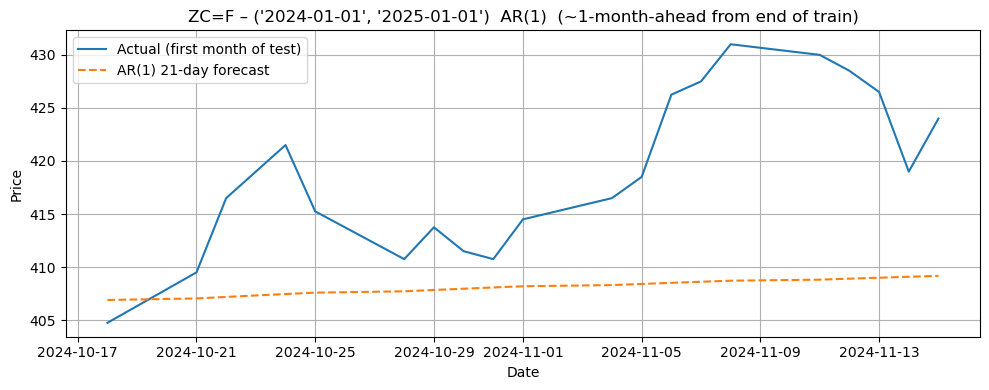

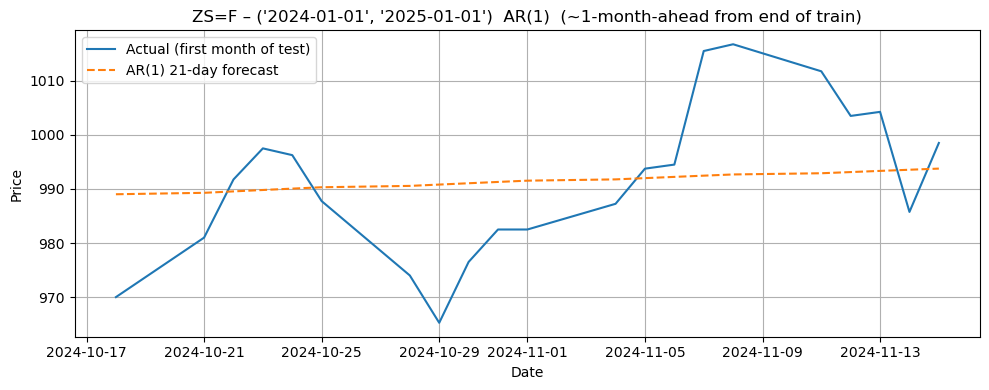

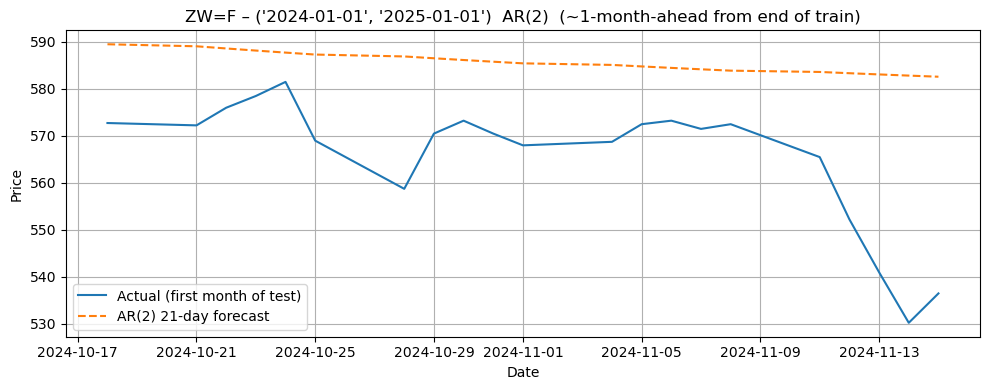

In [12]:
ar_month_ahead_metrics = {}

for year in years_sorted:
    print(f"\n=== AR month-ahead forecast: {year} ===")
    train_df = train_test_closes[year]['train'][tickers]
    test_df  = train_test_closes[year]['test'][tickers]

    ar_month_ahead_metrics[year] = {}

    for ticker in tickers:
        if ticker not in ar_year_to_models[year]:
            continue

        info = ar_year_to_models[year][ticker]
        p    = info["lags"]
        res  = info["model"]         # fitted AutoReg on TRAIN

        # numeric training series used to fit the model
        train_series = train_df[ticker].dropna()
        train_num = train_series.reset_index(drop=True)

        test_series = test_df[ticker].dropna()
        if test_series.empty:
            print(f"  {ticker}: no test data, skipping.")
            continue

        steps = min(h, len(test_series))

        # AR predict indices are relative to the training numeric index
        start = len(train_num)
        end   = start + steps - 1

        fc = res.predict(start=start, end=end)   # index: 0..start+steps-1

        # Align forecast with actual test dates
        forecast = pd.Series(fc.values, index=test_series.index[:steps], name="forecast")
        X_eval   = test_series.iloc[:steps]

        # Metrics
        errors = forecast - X_eval
        rmse = np.sqrt(np.mean(errors**2))
        mae  = np.mean(np.abs(errors))
        me   = np.mean(errors)

        ar_month_ahead_metrics[year][ticker] = {
            "lags": p,
            "rmse": rmse,
            "mae": mae,
            "me": me,
        }

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(X_eval.index, X_eval.values,
                 label="Actual (first month of test)")
        plt.plot(forecast.index, forecast.values, "--",
                 label=f"AR({p}) {steps}-day forecast")
        plt.title(f"{ticker} – {year}  AR({p})  (~1-month-ahead from end of train)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.close()

In [13]:
rows = []
for year, tickers_dict in ar_month_ahead_metrics.items():
    for ticker, m in tickers_dict.items():
        rows.append({
            "year": year,
            "ticker": ticker,
            "lags": m["lags"],
            "rmse": m["rmse"],
            "mae":  m["mae"],
            "me":   m["me"],
        })

ar_month_metrics_df = pd.DataFrame(rows)
ar_month_metrics_df

year ticker  lags       rmse        mae         me
0   (2001-01-01, 2002-01-01)   ZC=F     1   3.786791   3.152814   2.941041
1   (2001-01-01, 2002-01-01)   ZS=F     3   5.611295   4.904917   1.348860
2   (2001-01-01, 2002-01-01)   ZW=F     1  15.647462  14.871787 -14.871787
3   (2002-01-01, 2003-01-01)   ZC=F     1  11.333272   9.994874   9.994874
4   (2002-01-01, 2003-01-01)   ZS=F     1  15.496811  13.033529 -11.625680
..                       ...    ...   ...        ...        ...        ...
67  (2023-01-01, 2024-01-01)   ZS=F     1  26.845114  23.147282   4.292896
68  (2023-01-01, 2024-01-01)   ZW=F     6  20.484541  17.470939  14.597665
69  (2024-01-01, 2025-01-01)   ZC=F     1  12.698550  10.901882 -10.697118
70  (2024-01-01, 2025-01-01)   ZS=F     1  13.169400  10.894885   0.216828
71  (2024-01-01, 2025-01-01)   ZW=F     2  23.641516  20.198075  20.198075

[72 rows x 6 columns]